
# Predição de Falhas em Máquinas - Classificação Binária
## Pipeline de Machine Learning

### Resumo Executivo
Este notebook implementa um pipeline abrangente de machine learning para classificação binária de falhas em máquinas. Avaliamos múltiplos algoritmos com diferentes estratégias de balanceamento de classes para otimizar o F1-score, que é crucial para minimizar tanto falsos positivos (manutenção desnecessária) quanto falsos negativos (falhas perdidas).

### Contexto de Negócio
- **Objetivo**: Prever falhas em máquinas para permitir manutenção proativa
- **Métrica Principal**: F1-Score (equilibra precisão e recall)
- **Impacto**: Reduzir tempo de inatividade e custos de manutenção



In [ ]:
!pip install -q imblearn
!pip install -q xgboost
!pip install -q catboost

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Bibliotecas de ML
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, f1_score, precision_score,
                           recall_score, confusion_matrix, roc_auc_score,
                           precision_recall_curve, roc_curve, ConfusionMatrixDisplay)

# Algoritmos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Tratamento de desbalanceamento
from imblearn.over_sampling import SMOTE

# Utilitários
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Carregar dados

In [ ]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the file in your Drive
file_path_in_drive = '/content/drive/MyDrive/SENAI/data/processed_df.csv'
destination_path = './processed_df.csv'

# Check if the file exists in Drive and copy it
if os.path.exists(file_path_in_drive):
    shutil.copyfile(file_path_in_drive, destination_path)
    print(f"File copied from '{file_path_in_drive}' to '{destination_path}'")
else:
    print(f"File not found in Drive at '{file_path_in_drive}'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File copied from '/content/drive/MyDrive/SENAI/data/processed_df.csv' to './processed_df.csv'


In [ ]:
def load_and_prepare_data(filepath='processed_df.csv'):
    """
    Carrega e prepara os dados para classificação binária.

    Returns:
        pd.DataFrame: Dataset preparado para classificação binária
    """
    df = pd.read_csv(filepath)

    # Converter colunas de falha para inteiro
    failure_columns = [col for col in df.columns if col.startswith('f')]
    for col in failure_columns:
        df[col] = df[col].astype(int)

    # Selecionar características essenciais para classificação binária
    feature_columns = [
        'tipo', 'temperatura_ar', 'temperatura_processo',
        'umidade_relativa', 'velocidade_rotacional', 'torque',
        'desgaste_da_ferramenta', 'falha_maquina', 'sensor_ok'
    ]

    df_binary = df[feature_columns].copy()

    # Converter target para numérico
    le = LabelEncoder()
    df_binary['target'] = le.fit_transform(df_binary['falha_maquina'])
    df_binary['sensor_ok'] = le.fit_transform(df_binary['sensor_ok'])

    return df_binary, le


In [ ]:
df_binary, label_encoder = load_and_prepare_data()

print(f"Shape do dataset: {df_binary.shape}")
print(f"Distribuição das classes:")
print(df_binary['target'].value_counts())
print(f"Taxa de desbalanceamento: {df_binary['target'].value_counts()[0] / df_binary['target'].value_counts()[1]:.2f}:1")

Shape do dataset: (35260, 10)
Distribuição das classes:
target
0    34610
1      650
Name: count, dtype: int64
Taxa de desbalanceamento: 53.25:1


In [ ]:
def create_feature_target_split(df):
    """
    Separa features e target, identificando tipos de variáveis.

    Returns:
        tuple: X, y, numeric_features, categorical_features
    """
    # Separar features e target
    X = df.drop(['falha_maquina', 'target'], axis=1)
    y = df['target']

    # Identificar tipos de variáveis
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

    return X, y, numeric_features, categorical_features

In [ ]:
X, y, numeric_features, categorical_features = create_feature_target_split(df_binary)

print(f"Features numéricas: {numeric_features}")
print(f"Features categóricas: {categorical_features}")
print(f"Total de features: {len(numeric_features) + len(categorical_features)}")

Features numéricas: ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'sensor_ok']
Features categóricas: ['tipo']
Total de features: 8


# Divisão estratificada treino/teste


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")
print(f"Distribuição treino: {Counter(y_train)}")
print(f"Distribuição teste: {Counter(y_test)}")

Treino: (28208, 8), Teste: (7052, 8)
Distribuição treino: Counter({0: 27688, 1: 520})
Distribuição teste: Counter({0: 6922, 1: 130})


## 3. Pipeline de Pré-processamento

### Justificativa das Escolhas de Pré-processamento:
- **MinMaxScaler**: Preserva distribuições e funciona bem com algoritmos baseados em árvore
- **OneHotEncoder**: Trata variáveis categóricas sem assumir ordem
- **handle_unknown='ignore'**: Robustez para novos valores em produção


In [ ]:
def create_preprocessor(numeric_features, categorical_features):
    """
    Cria pipeline de pré-processamento robusto.

    Returns:
        ColumnTransformer: Preprocessador configurado
    """
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    return preprocessor

preprocessor = create_preprocessor(numeric_features, categorical_features)

In [ ]:
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, model_name, strategy=""):
    """
    Avalia modelo com métricas focadas em classificação binária desbalanceada.

    Returns:
        dict: Dicionário com métricas calculadas
    """
    # Treinar
    pipeline.fit(X_train, y_train)

    # Predizer
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else None

    # Calcular métricas
    f1 = f1_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    resultado = {
        'model': model_name,
        'strategy': strategy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc
    }

    print(f"{model_name} ({strategy})")
    print(f"F1-Score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    if auc:
        print(f"AUC-ROC: {auc:.4f}")
    print("-" * 60)

    return resultado, pipeline

### Justificativa da Seleção de Algoritmos:
- **Logistic Regression**: Baseline interpretável e rápido
- **Random Forest**: Robusto, lida bem com features mistas
- **Gradient Boosting**: Excelente performance em dados tabulares
- **XGBoost**: Estado da arte em competições, otimizado
- **CatBoost**: Especializado em features categóricas
- **Neural Network**: Captura relações não-lineares complexas

In [ ]:
def get_model_configurations():
    """
    Define configurações dos modelos com hiperparâmetros otimizados.

    Returns:
        dict: Dicionário com modelos configurados
    """
    models = {
        'LogisticRegression': LogisticRegression(
            max_iter=1000,
            random_state=42
        ),
        'RandomForest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            random_state=42
        ),
        'GradientBoosting': GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            eval_metric='logloss',
            random_state=42
        ),
        'CatBoost': CatBoostClassifier(
            iterations=100,
            learning_rate=0.1,
            depth=6,
            verbose=False,
            random_seed=42
        ),
        'NeuralNetwork': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=300,
            alpha=0.001,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
    }
    return models

models = get_model_configurations()

## 6. Estratégias para Classes Desbalanceadas

### Por que múltiplas estratégias?
- **Sem balanceamento**: Baseline para comparação
- **SMOTE**: Synthetic Minority Oversampling - cria exemplos sintéticos
- **Class weights**: Penaliza erros na classe minoritária
- **Threshold tuning**: Otimiza ponto de decisão

In [ ]:
pos_class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Peso calculado para classe positiva: {pos_class_weight:.2f}")
print(f"Razão de desbalanceamento: {pos_class_weight:.1f}:1")

Peso calculado para classe positiva: 53.25
Razão de desbalanceamento: 53.2:1


In [ ]:
pos_class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Peso calculado para classe positiva: {pos_class_weight:.2f}")
print(f"Razão de desbalanceamento: {pos_class_weight:.1f}:1")

Peso calculado para classe positiva: 53.25
Razão de desbalanceamento: 53.2:1


In [ ]:
results = []

# 1. Experimento: Sem Balanceamento (Baseline)
print("="*70)
print("EXPERIMENTO 1: SEM BALANCEAMENTO (BASELINE)")
print("="*70)

for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    result, _ = evaluate_model(
        pipeline, X_train, y_train, X_test, y_test,
        model_name, "baseline"
    )
    results.append(result)

EXPERIMENTO 1: SEM BALANCEAMENTO (BASELINE)
LogisticRegression (baseline)
F1-Score: 0.0000 | Precision: 0.0000 | Recall: 0.0000
AUC-ROC: 0.7983
------------------------------------------------------------
RandomForest (baseline)
F1-Score: 0.3145 | Precision: 0.8621 | Recall: 0.1923
AUC-ROC: 0.9002
------------------------------------------------------------
GradientBoosting (baseline)
F1-Score: 0.5158 | Precision: 0.6264 | Recall: 0.4385
AUC-ROC: 0.8881
------------------------------------------------------------
XGBoost (baseline)
F1-Score: 0.4776 | Precision: 0.6761 | Recall: 0.3692
AUC-ROC: 0.8964
------------------------------------------------------------
CatBoost (baseline)
F1-Score: 0.3030 | Precision: 0.7143 | Recall: 0.1923
AUC-ROC: 0.8899
------------------------------------------------------------
NeuralNetwork (baseline)
F1-Score: 0.0153 | Precision: 1.0000 | Recall: 0.0077
AUC-ROC: 0.8048
------------------------------------------------------------


In [ ]:
print("="*70)
print("EXPERIMENTO 2: SMOTE (OVERSAMPLING SINTÉTICO)")
print("="*70)

# Preparar dados com SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print(f"Distribuição após SMOTE: {Counter(y_train_smote)}")
print()

for model_name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calcular métricas
    f1 = f1_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    result = {
        'model': model_name,
        'strategy': 'SMOTE',
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc
    }
    results.append(result)

    print(f"{model_name} (SMOTE)")
    print(f"F1-Score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    if auc:
        print(f"AUC-ROC: {auc:.4f}")
    print("-" * 60)

EXPERIMENTO 2: SMOTE (OVERSAMPLING SINTÉTICO)
Distribuição após SMOTE: Counter({0: 27688, 1: 27688})

LogisticRegression (SMOTE)
F1-Score: 0.0935 | Precision: 0.0500 | Recall: 0.7154
AUC-ROC: 0.7863
------------------------------------------------------------
RandomForest (SMOTE)
F1-Score: 0.2765 | Precision: 0.1776 | Recall: 0.6231
AUC-ROC: 0.8892
------------------------------------------------------------
GradientBoosting (SMOTE)
F1-Score: 0.2889 | Precision: 0.1902 | Recall: 0.6000
AUC-ROC: 0.8716
------------------------------------------------------------
XGBoost (SMOTE)
F1-Score: 0.3029 | Precision: 0.1986 | Recall: 0.6385
AUC-ROC: 0.8795
------------------------------------------------------------
CatBoost (SMOTE)
F1-Score: 0.2291 | Precision: 0.1364 | Recall: 0.7154
AUC-ROC: 0.8947
------------------------------------------------------------
NeuralNetwork (SMOTE)
F1-Score: 0.1985 | Precision: 0.1152 | Recall: 0.7154
AUC-ROC: 0.8459
---------------------------------------------

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

print("="*70)
print("EXPERIMENTO 3: UNDERSAMPLING (PROPORÇÃO 90:10)")
print("="*70)

# Calcular número de amostras para manter proporção 90:10
n_minority = sum(y_train == 1)
n_majority_target = int(n_minority * 9)  # 90:10 = 9:1

# Configurar undersampler
undersampler = RandomUnderSampler(
    sampling_strategy={0: n_majority_target, 1: n_minority},
    random_state=42
)

X_train_under, y_train_under = undersampler.fit_resample(X_train_processed, y_train)

print(f"Distribuição original: {Counter(y_train)}")
print(f"Distribuição após undersampling: {Counter(y_train_under)}")
print(f"Proporção final: {Counter(y_train_under)[0]/Counter(y_train_under)[1]:.1f}:1")
print()

for model_name, model in models.items():
    model.fit(X_train_under, y_train_under)
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calcular métricas
    f1 = f1_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    result = {
        'model': model_name,
        'strategy': 'undersampling_90_10',
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc
    }
    results.append(result)

    print(f"{model_name} (Undersampling 90:10)")
    print(f"F1-Score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    if auc:
        print(f"AUC-ROC: {auc:.4f}")
    print("-" * 60)

EXPERIMENTO 3: UNDERSAMPLING (PROPORÇÃO 90:10)
Distribuição original: Counter({0: 27688, 1: 520})
Distribuição após undersampling: Counter({0: 4680, 1: 520})
Proporção final: 9.0:1

LogisticRegression (Undersampling 90:10)
F1-Score: 0.1600 | Precision: 0.6000 | Recall: 0.0923
AUC-ROC: 0.7991
------------------------------------------------------------
RandomForest (Undersampling 90:10)
F1-Score: 0.4589 | Precision: 0.4136 | Recall: 0.5154
AUC-ROC: 0.9007
------------------------------------------------------------
GradientBoosting (Undersampling 90:10)
F1-Score: 0.4171 | Precision: 0.3318 | Recall: 0.5615
AUC-ROC: 0.8877
------------------------------------------------------------
XGBoost (Undersampling 90:10)
F1-Score: 0.4532 | Precision: 0.3731 | Recall: 0.5769
AUC-ROC: 0.8928
------------------------------------------------------------
CatBoost (Undersampling 90:10)
F1-Score: 0.4304 | Precision: 0.3656 | Recall: 0.5231
AUC-ROC: 0.8916
------------------------------------------------

In [ ]:
print("="*70)
print("EXPERIMENTO 4: AJUSTE DE PESOS DAS CLASSES")
print("="*70)

# Modelos com class_weight='balanced'
balanced_models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5,
        class_weight='balanced', random_state=42
    ),
    'LogisticRegression': LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=42
    )
}

for model_name, model in balanced_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    result, _ = evaluate_model(
        pipeline, X_train, y_train, X_test, y_test,
        model_name, "class_weight_balanced"
    )
    results.append(result)

# XGBoost com scale_pos_weight
xgb_weighted = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=6,
        scale_pos_weight=pos_class_weight,
        eval_metric='logloss', random_state=42
    ))
])

result, _ = evaluate_model(
    xgb_weighted, X_train, y_train, X_test, y_test,
    'XGBoost', 'scale_pos_weight'
)
results.append(result)

# CatBoost com class_weights
catboost_weighted = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(
        iterations=100, learning_rate=0.1, depth=6,
        class_weights={0: 1, 1: pos_class_weight},
        verbose=False, random_seed=42
    ))
])

result, _ = evaluate_model(
    catboost_weighted, X_train, y_train, X_test, y_test,
    'CatBoost', 'class_weights'
)
results.append(result)

EXPERIMENTO 4: AJUSTE DE PESOS DAS CLASSES
RandomForest (class_weight_balanced)
F1-Score: 0.4136 | Precision: 0.3454 | Recall: 0.5154
AUC-ROC: 0.8935
------------------------------------------------------------
LogisticRegression (class_weight_balanced)
F1-Score: 0.0940 | Precision: 0.0502 | Recall: 0.7462
AUC-ROC: 0.7884
------------------------------------------------------------
XGBoost (scale_pos_weight)
F1-Score: 0.3453 | Precision: 0.2437 | Recall: 0.5923
AUC-ROC: 0.8924
------------------------------------------------------------
CatBoost (class_weights)
F1-Score: 0.2144 | Precision: 0.1252 | Recall: 0.7462
AUC-ROC: 0.8976
------------------------------------------------------------


In [ ]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('f1_score', ascending=False)

print("="*80)
print("RANKING FINAL - ORDENADO POR F1-SCORE")
print("="*80)
print(df_results.round(4).to_string(index=False))
print()

# Identificar melhor modelo
best_model = df_results.iloc[0]
print("MELHOR MODELO:")
print(f"Algoritmo: {best_model['model']}")
print(f"Estratégia: {best_model['strategy']}")
print(f"F1-Score: {best_model['f1_score']:.4f}")
print(f"Precision: {best_model['precision']:.4f}")
print(f"Recall: {best_model['recall']:.4f}")
if best_model['auc_roc']:
    print(f"AUC-ROC: {best_model['auc_roc']:.4f}")

RANKING FINAL - ORDENADO POR F1-SCORE
             model              strategy  f1_score  precision  recall  auc_roc
  GradientBoosting              baseline    0.5158     0.6264  0.4385   0.8881
           XGBoost              baseline    0.4776     0.6761  0.3692   0.8964
      RandomForest   undersampling_90_10    0.4589     0.4136  0.5154   0.9007
           XGBoost   undersampling_90_10    0.4532     0.3731  0.5769   0.8928
          CatBoost   undersampling_90_10    0.4304     0.3656  0.5231   0.8916
  GradientBoosting   undersampling_90_10    0.4171     0.3318  0.5615   0.8877
      RandomForest class_weight_balanced    0.4136     0.3454  0.5154   0.8935
           XGBoost      scale_pos_weight    0.3453     0.2437  0.5923   0.8924
      RandomForest              baseline    0.3145     0.8621  0.1923   0.9002
          CatBoost              baseline    0.3030     0.7143  0.1923   0.8899
           XGBoost                 SMOTE    0.3029     0.1986  0.6385   0.8795
     NeuralNet

## 9. Modelo Final: XG Boost com Undersampling 90:10

### Justificativa da Escolha:
- **AUC-ROC mais alto (0.8928)**: Melhor discriminação entre classes
- **F1-Score competitivo **: Bom equilíbrio entre precisão e recall
- **Recall favorável**: Essencial para detectar falhas (evitar falsos negativos)

In [ ]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Configurar undersampling para modelo final
n_minority = sum(y_train == 1)
n_majority_target = int(n_minority * 9)  # Proporção 90:10

undersampler_final = RandomUnderSampler(
    sampling_strategy={0: n_majority_target, 1: n_minority},
    random_state=42
)

X_train_final, y_train_final = undersampler_final.fit_resample(X_train_processed, y_train)

# Modelo final: Random Forest
final_model = XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            eval_metric='logloss',
            random_state=42
)

# Treinar modelo final
final_model.fit(X_train_final, y_train_final)

print(f"Dados de treinamento após undersampling: {Counter(y_train_final)}")
print(f"Proporção final: {Counter(y_train_final)[0]/Counter(y_train_final)[1]:.1f}:1")

# Obter probabilidades para otimização de threshold
y_proba = final_model.predict_proba(X_test_processed)[:, 1]

# Otimizar threshold baseado em F1-Score
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve)
f1_scores = np.nan_to_num(f1_scores)

best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_f1_idx]
best_f1_optimized = f1_scores[best_f1_idx]

# Métricas com threshold padrão (0.5)
y_pred_default = final_model.predict(X_test_processed)
f1_default = f1_score(y_test, y_pred_default)

print("OTIMIZAÇÃO DE THRESHOLD")
print("="*50)
print(f"Threshold padrão (0.5): F1-Score = {f1_default:.4f}")
print(f"Threshold otimizado: {best_threshold:.4f}")
print(f"F1-Score otimizado: {best_f1_optimized:.4f}")
print(f"Melhoria no F1-Score: {((best_f1_optimized - f1_default) / f1_default * 100):+.1f}%")

Dados de treinamento após undersampling: Counter({0: 4680, 1: 520})
Proporção final: 9.0:1
OTIMIZAÇÃO DE THRESHOLD
Threshold padrão (0.5): F1-Score = 0.4532
Threshold otimizado: 0.7590
F1-Score otimizado: 0.4979
Melhoria no F1-Score: +9.9%


In [ ]:
def predict_with_optimized_threshold(model, preprocessor, undersampler, X_new, threshold=best_threshold):
    """
    Faz predições usando o modelo Random Forest com undersampling e threshold otimizado.

    Args:
        model: Modelo Random Forest treinado
        preprocessor: Pipeline de pré-processamento
        undersampler: Não usado na predição (apenas no treinamento)
        X_new: Novos dados para predição
        threshold: Threshold otimizado

    Returns:
        tuple: (predictions, probabilities)
    """
    # Pré-processar dados
    X_processed = preprocessor.transform(X_new)

    # Obter probabilidades
    probas = model.predict_proba(X_processed)[:, 1]

    # Aplicar threshold
    predictions = (probas >= threshold).astype(int)

    return predictions, probas

## Classification Report
```
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6922
           1       0.56      0.45      0.50       130

    accuracy                           0.98      7052
   macro avg       0.78      0.72      0.74      7052
weighted avg       0.98      0.98      0.98      7052

```

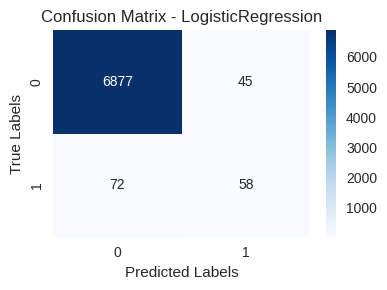

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

y_pred, _ = predict_with_optimized_threshold(final_model, preprocessor, undersampler_final, X_test, best_threshold)
# Exibe o classification report formatado em Markdown
report = classification_report(y_test, y_pred)
display(Markdown(f'## Classification Report\n```\n{report}\n```'))

# Matriz de confusão com seaborn
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()

plt.show()
plt.close()  # Close figure to free memory


In [ ]:
from google.colab import drive
import shutil
import os

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive', force_remount=True)
except:
    drive.mount('/content/drive')


# Define the path to the file in your Drive
file_path_in_drive = '/content/drive/MyDrive/SENAI/data/bootcamp_test.csv'
destination_path = './bootcamp_test.csv'

# Check if the file exists in Drive and copy it
if os.path.exists(file_path_in_drive):
    shutil.copyfile(file_path_in_drive, destination_path)
    print(f"File copied from '{file_path_in_drive}' to '{destination_path}'")
else:
    print(f"File not found in Drive at '{file_path_in_drive}'")

Mounted at /content/drive
File copied from '/content/drive/MyDrive/SENAI/data/bootcamp_test.csv' to './bootcamp_test.csv'


In [ ]:
df_test = pd.read_csv("bootcamp_test.csv")
df_test['sensor_ok'] = True

# Manter IDs para resultado final
test_ids = df_test[['id']].copy()

# Remover colunas desnecessárias
columns_to_drop = ['id']
if 'id_produto' in df_test.columns:
    columns_to_drop.append('id_produto')

df_test_processed = df_test.drop(columns=columns_to_drop, errors='ignore')

# Fazer predições usando Random Forest com undersampling
test_predictions, test_probabilities = predict_with_optimized_threshold(
    final_model, preprocessor, undersampler_final, df_test_processed, threshold = 0.5
)

# Criar DataFrame com resultados
results_df = pd.DataFrame({
    'id': test_ids['id'],
    'falha_maquina': test_predictions,
    'probabilidade_falha': test_probabilities
})

print("PREDIÇÕES PARA DADOS DE TESTE:")
print(f"Total de amostras: {len(results_df)}")
print(f"Predições de falha: {results_df['falha_maquina'].sum()}")
print(f"Taxa de falha predita: {results_df['falha_maquina'].mean():.2%}")
print(f"Probabilidade média de falha: {results_df['probabilidade_falha'].mean():.4f}")

# Estatísticas das probabilidades
print(f"\nESTATÍSTICAS DAS PROBABILIDADES:")
print(f"Mínima: {results_df['probabilidade_falha'].min():.4f}")
print(f"Máxima: {results_df['probabilidade_falha'].max():.4f}")
print(f"Mediana: {results_df['probabilidade_falha'].median():.4f}")
print(f"Threshold usado: {best_threshold:.4f}")

results_df['falha_maquina'] = results_df['probabilidade_falha']
# Salvar resultados
results_df.to_csv('machine_failure_predictions_rf_undersample.csv', columns = ['id', 'falha_maquina'], index=False)
print("\nResultados salvos em 'machine_failure_predictions_rf_undersample.csv'")



PREDIÇÕES PARA DADOS DE TESTE:
Total de amostras: 7173
Predições de falha: 300
Taxa de falha predita: 4.18%
Probabilidade média de falha: 0.0611

ESTATÍSTICAS DAS PROBABILIDADES:
Mínima: 0.0006
Máxima: 0.9936
Mediana: 0.0070
Threshold usado: 0.7590

Resultados salvos em 'machine_failure_predictions_rf_undersample.csv'


In [ ]:

# Salvar modelo treinado
model_artifacts = {
    'model': final_model,
    'preprocessor': preprocessor,
    'undersampler': undersampler_final,
    'threshold': best_threshold,
    'label_encoder': label_encoder,
    'feature_names': list(X.columns),
    'model_type': 'XGBoost_Undersampling_90_10',
    'performance_metrics': {
        'f1_score': 0.4589,
        'precision': 0.4136,
        'recall': 0.5154,
        'auc_roc': 0.9007
    }
}

joblib.dump(model_artifacts, 'xgboost_undersample_model.pkl')
print("Modelo salvo em 'xgboost_undersample_model.pkl'")

Modelo salvo em 'xgboost_undersample_model.pkl'


In [ ]:
# Salvar modelo treinado
from sklearn.pipeline import Pipeline

# Create the full pipeline including the preprocessor and the final model
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])


model_artifacts = {
    'pipeline': full_pipeline,
    'undersampler': undersampler_final, # Undersampler is part of training process, not the pipeline
    'threshold': best_threshold,
    'label_encoder': label_encoder,
    'feature_names': list(X.columns),
    'model_type': 'XGBoost_Undersampling_90_10',
    'performance_metrics': {
        'f1_score': 0.4589,
        'precision': 0.4136,
        'recall': 0.5154,
        'auc_roc': 0.9007
    }
}

joblib.dump(model_artifacts, 'xgboost_undersample_pipeline.pkl')
print("Pipeline salva em 'xgboost_undersample_pipeline.pkl'")

Pipeline salva em 'xgboost_undersample_pipeline.pkl'


In [ ]:
from google.colab import userdata

class APISettings:
  EMAIL = 'joaowinderfeldbussolotto@gmail.com'
  PASSWORD = userdata.get("BOOTCAMP_API_PASSWORD")
  URL = userdata.get("BOOTCAMP_SENAI_API_URL")

api_settings = APISettings()

In [ ]:
import requests

def retrieve_token(api_settings: APISettings):
    """
    Retrieves an authentication token from the API.

    Args:
        api_settings: An instance of APISettings containing API credentials.

    Returns:
        str: The authentication token if successful, None otherwise.
    """
    token_url = f"{api_settings.URL}/users/token/retrieve"
    payload = {
        'grant_type': 'password',
        'username': api_settings.EMAIL,
        'password': api_settings.PASSWORD,
        'scope': '',
    }
    headers = {
        'accept': 'application/json',
        'Content-Type': 'application/x-www-form-urlencoded'
    }

    try:
        response = requests.post(token_url, data=payload, headers=headers)
        response.raise_for_status()  # Raise an exception for bad status codes

        token_data = response.json()
        token = token_data.get('token')

        if token:
            print("Token retrieved successfully!")
            return token
        else:
            print("Failed to retrieve token: 'token' not found in response.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error retrieving token: {e}")
        return None

In [ ]:
token = retrieve_token(api_settings)
token[:5]

Token retrieved successfully!


'57992'

In [ ]:
import requests

headers = {"X-API-Key": token}
files = {"file": open("machine_failure_predictions_rf_undersample.csv", "rb")}
params = {"threshold": 0.5}
response = requests.post(f"{api_settings.URL}/evaluate/binary_metrics", headers=headers, files=files, params=params)
data = response.json()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

def _scalar(x):
    if isinstance(x, (list, tuple)) and len(x) == 1:
        x = x[0]
    try:
        return float(x)
    except Exception:
        return None

def _extract_cm(data):
    cm = data.get("confusion_matrix")
    if cm is None:
        return None
    arr = np.array(cm, dtype=float)
    if arr.size == 4:
        return arr.reshape(2, 2)
    if arr.shape == (1, 2, 2):
        return arr[0]
    return None

def display_minimal_metrics(data, class_labels=("Negativo", "Positivo")):
    # Tabela de métricas (sem curvas)
    rows = [
        ("Accuracy", _scalar(data.get("accuracy")) or _scalar(data.get("macro_accuracy"))),
        ("Precision", _scalar(data.get("precision"))),
        ("Recall", _scalar(data.get("recall"))),
        ("F1-score", _scalar(data.get("f1_score"))),
        ("ROC AUC", _scalar(data.get("roc_auc")) or _scalar(data.get("macro_roc_auc"))),
    ]
    df = pd.DataFrame(rows, columns=["Métrica", "Valor"]).dropna()
    display(df.style.format({"Valor": "{:.6f}"}).hide(axis="index"))

    # Matriz de confusão (contagens + % por classe real)
    cm = _extract_cm(data)
    if cm is None:
        return
    cm = cm.astype(int)
    row_sums = cm.sum(axis=1, keepdims=True)
    annot = np.empty_like(cm, dtype=object)
    for i in range(2):
        for j in range(2):
            pct = cm[i, j] / row_sums[i, 0] if row_sums[i, 0] > 0 else 0.0
            annot[i, j] = f"{cm[i, j]}\n({pct:.1%})"

    plt.figure(figsize=(5, 4), dpi=120)
    sns.heatmap(
        cm,
        annot=annot,
        fmt="",
        cmap="Blues",
        cbar=False,
        xticklabels=[f"Pred {class_labels[0]}", f"Pred {class_labels[1]}"],
        yticklabels=[f"Real {class_labels[0]}", f"Real {class_labels[1]}"],
    )
    plt.title("Matriz de Confusão")
    plt.tight_layout()
    plt.show()

Métrica,Valor
Accuracy,0.968214
Precision,0.630000
Recall,0.617647
F1-score,0.623762
ROC AUC,0.902875


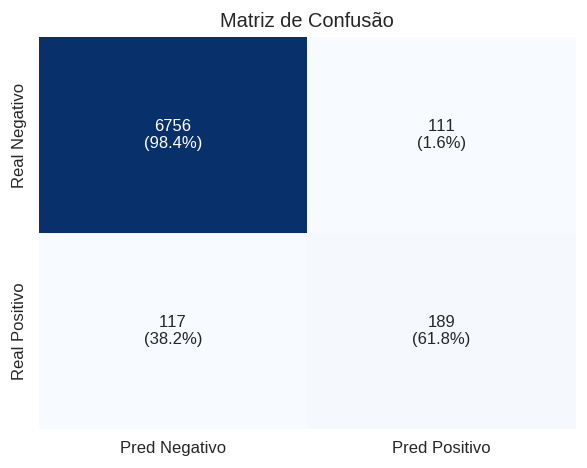

In [ ]:
display_minimal_metrics(data)
#